# **Aprendizaje Automático**. 
## Práctica Entregable 1.





### Preparativos
Esta práctica consiste en la implementación de una red neuronal que clasifique imágenes según su categoría. Se os da acceso a un dataset que debéis usar para entrenar, y se evaluará usando un conjunto de test al que no tenéis acceso.

Vamos a ver primero como cargar el dataset y visualizar qué contiene.

In [4]:
from io import BytesIO
import numpy as np
import requests
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import rotate
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import pickle
from torchsummary import summary

Lo primero que haremos será descargarnos el conjunto de entrenamiento de la práctica. Consiste en un dataset de imágenes de 32$\times$32 píxeles de objetos de 5 categorías diferentes. Los datos están encapsulados en una estructura de tipo diccionario y almacenado en formato [`Pickle`](https://docs.python.org/3/library/pickle.html), muy módulo usado en Machine Learning para guardar y compartir datos.  

In [5]:
if 'icons' not in locals():
  !wget https://www.dropbox.com/s/jgjuf2t0enioz1n/iconos_train.pkl
  with open('/content/iconos_train.pkl', 'rb') as handle:
      icons = pickle.load(handle)




--2021-12-12 14:13:22--  https://www.dropbox.com/s/jgjuf2t0enioz1n/iconos_train.pkl
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jgjuf2t0enioz1n/iconos_train.pkl [following]
--2021-12-12 14:13:22--  https://www.dropbox.com/s/raw/jgjuf2t0enioz1n/iconos_train.pkl
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucec61914121711155f5e52a673e.dl.dropboxusercontent.com/cd/0/inline/Bbsoe96khMjSVz49OM5I-NXR6huXt6mU7EbPO-APndR5HRKasgGQPGHVK_CuKIobUlWJDESbFBg8dMHwwf0TAGIDgxemWl4ZWMw9FQbCQ7Y9oZ4cj8xE06buDzorxS4WF6wn_hJ73_4cF7oJPYRinmUj/file# [following]
--2021-12-12 14:13:23--  https://ucec61914121711155f5e52a673e.dl.dropboxusercontent.com/cd/0/inline/Bbsoe96khMjSVz49OM5I-NXR6huXt6mU7EbPO-APndR5HRKasgGQPGHVK_CuKIobUlWJDESbFBg8dM

Para ver que todo ha funcionado bien podemos, por ejemplo, visualizar el primer elemento de nuestro dataset. Para ello, primer listaremos las `keys` (es decir, los tipos de campos) del diccionario que hemos cargado. Seguidamente, usamos la función `shape` para averiguar el tamaño de cada tipo de dato. 

In [6]:
print(icons.keys())
icons['images'].shape
#icons['labels'].shape

dict_keys(['images', 'labels'])


(1005, 3, 32, 32)

Una vez hemos comprobado que tenemos un `key` llamado `images` con datos de tamaño  1005$\times$3$\times$32$\times$32 , y otro `key` llamado `labels` de tamaño 1, podemos usar la función `imshow` para visualizar una imagen así como `print` para ver si etiqueta.

Etiqueta:  1


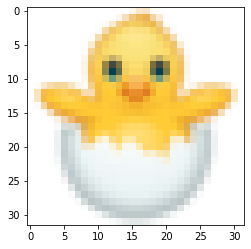

In [7]:
# visualiza la primera imagen

im = icons['images'][1].transpose()
plt.imshow(im)
print("Etiqueta: ", icons['labels'][1])

Vamos a visualizar las 100 primeras muestras del dataset. Como veis las etiquetas pueden 0,1,2,3,4.

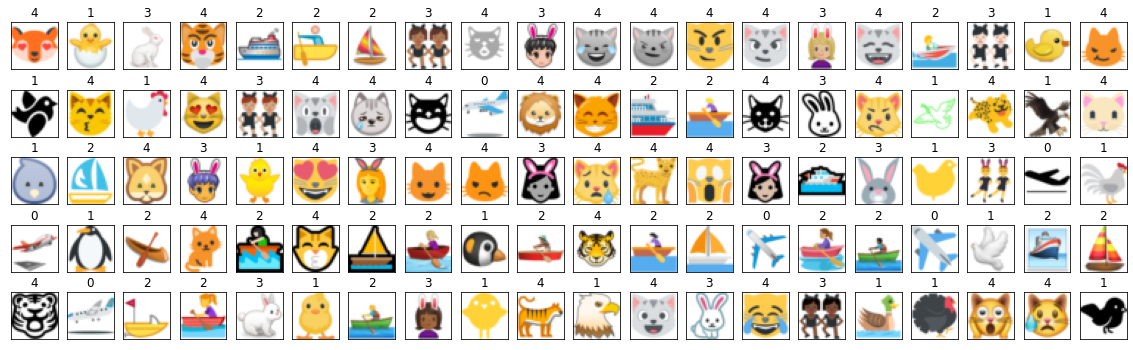

In [ ]:
number_of_icons_to_show = 100
fig = plt.figure(figsize=(20, 6))
for idx in np.arange(number_of_icons_to_show):
  ax = fig.add_subplot(5, 20, idx+1, xticks=[], yticks=[])
  ax.imshow(icons['images'][idx].transpose(2,1,0))
  ax.set_title(str(icons['labels'][idx]))


### Instrucciones
Con esta información disponible, se pide que implementéis una red neuronal que dada una imagen de entrada devuelva su categoría. 

Recuerda que en clase, para este tipo de problemas, hemos usado una loss del tipo `nn.CrossEntropyLoss()`, puedes fijarte en el ejemplo que vimos con el dataset de digitos MNIST. En este caso, las imagenes tienen 3 canales (ya que son en color), así que tendréis que tener esto en cuenta a la hora de diseñar una arquitectura de una red densa o convolucional. Podéis diseñar la red que queráis.

Para evaluar vuestro trabajo, voy a usar un conjunto de datos de test que no voy a compartir. Quien obtenga un mayor número de aciertos en el conjunto de test, tendrá **1 punto adicional**.

### Entrega
Deberéis entregar
*   El código de la práctica en un archivo llamado `practica1_[apellidos]_[nombre].ipynb` , por ejemplo `practica1_casas_guix_dan.ipynb`, que se pueda ejecutar para entrenar el modelo que presentéis. Lo tenéis que implementar directamente en este Google Colab, empezando al final de este enunciado. Para entregarlo, lo podéis descargar desde `File`->`Download`->`Download .ipynb`. Vuestro código tiene que incluir todo lo habitual para este tipo de problemas: 
    1.   Dividir el dataset en conjunto de entrenamiento y validación (el conjunto de test es secreto, y no lo comparto).
    2.   Diseñe una arquitectura
    3.   Un bucle de entrenamiento
    4.   Gráficas de los valores de la loss a lo largo de un entrenamiento
    5.   Una evaluación del % de aciertos de vuestro conjunto de entrenamiento y validación.

*   La red que entrenéis se tiene que llamar `modelo` y tiene que recibir como entrada una imágen y devolver un vector $\mathbb{R}^5$ con un $1$ en la posición correspondiente a la etiqueta de la imagen de entrada. Por ejemplo, si `im1` es una imagen de un avión, `modelo(im1)` tiene que devolver idealmente un vector `[1.0, 0.0, 0.0, 0.0, 0.0]`. Esto es exactamente igual que el ejemplo de MNIST que vimos en clase, podéis basaros en aquel código. Para corregirla voy a usar un script que llamará a `modelo` de la manera que se os describe, así que es importante que os ajustéis a las instrucciones.
*   Una memoria en formato `.pdf` que contenga los apartados: 
   1.   Descripción del problema.
   2.   Solución propuesta. Aquí debes describir la red que propones (número de capas, funciones de activación, etc.). 
   3.   Resultados y Evaluación. Incluye alguna figura con los resultados que obtienes, y comenta los fallos que pueda hacer vuestra red en el conjunto de validación. Describe también qué efectos producen los hiperparámetros de tu modelo (por ej., qué pasa cuando subes el learnig rate, o el batch size). También puedes comentar diferentes arquitecutras que hayas probado, y cual era el resultado. Por ejemplo, ¿te ha funcionado con una red densa? ¿Que resultados obtenías?

La fecha máxima de entrega será **domingo 12 de diciembre a las 23.59**. Se va ha habilitar una entrega por Aula Virtual en la que hay que entregar el Notebook en formato `.npynb` y la memoria en formato `.pdf`.






Dividir el dataset en conjunto de entrenamiento y validación.
Para ello utilizo la función train_test_split, que recibe como entrada las imágenes y labels del dataset y devuelve los conjuntos de entrenamiento y validacion. Después hay que agrupartos en datasets y crear el train_loader y valid_loader

In [181]:
#train_img, valid_img, train_lab, valid_lab=train_test_split(icons['images'],icons['labels'],train_size=0.891) #5 batch
train_img, valid_img, train_lab, valid_lab=train_test_split(icons['images'],icons['labels'],train_size=0.797)
print(f'Tamaño del conjunto de entrenamiento: {train_img.shape}. Tamaño del conjunto de validación: {valid_img.shape}')
#Convertir a tensor
train_img=torch.Tensor(train_img)
train_lab=torch.Tensor(train_lab)
valid_img=torch.Tensor(valid_img)
valid_lab=torch.Tensor(valid_lab)

#Normalizar
train_img=train_img/255
valid_img=valid_img/255

#definir el batch_size
batch_size =10
trainset = TensorDataset(train_img, train_lab)
validset = TensorDataset(valid_img, valid_lab)

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(validset, batch_size=batch_size, shuffle=True)

Tamaño del conjunto de entrenamiento: (800, 3, 32, 32). Tamaño del conjunto de validación: (205, 3, 32, 32)


Diseñar arquitectura:

In [184]:
#32x32 1024
# definimos la arquitecutra de la red
class Net(nn.Module):
  def __init__(self, num_channels, num_classes):
    super(Net, self).__init__()
     # Capa convolucional
    # Los parámetros de Conv2 son:
    #  - channel_input: numero de canales de la imagen de entrada. En este caso 3 ya que es una imagen en color
    #  - channels output: número de filtros (hay un canal de salida por cada filtro). se usarán 32 filtros.
    #  - tamaño del filtro: 3 x 3 (kernel de convolucion)
    #  - stride: offset entre una convolución y la siguiente
    #  - si queremos padding: rellenar con 0 los bordes donde los filtros salen de la imagen. Si se usa padding hay dos píxeles más en la longitud y el ancho de la imagen
         #((CanalesEntrada-KernelSize+2*padding)/stride)+1       
    self.conv1=nn.Conv2d(num_channels,32, 3, stride=2, padding=1 )      #Tamaño nuevo  16
    self.pool1=nn.MaxPool2d(2)        #tamaño nuevo 8
    self.conv2=nn.Conv2d(32, 64, 3, stride=1, padding=1)  # 8
    #self.pool2=nn.MaxPool2d(2);  #  4
    self.fc1=nn.Linear(64*8*8,256)
    self.fc2=nn.Linear(256, 5)

  #Recibe la entrada y devuelve la salida
  def forward(self, X):
      x=F.relu(self.conv1(X)); #lo paso a la capa convolucional 1
      x=self.pool1(x);#capa pooling
      x=F.relu(self.conv2(x))
     # x=self.pool2(x)
      x=x.reshape(-1,8*8*64)
      x=F.relu(self.fc1(x))
      x=self.fc2(x);

      return x;

# inicializa la red
modelo = Net(3,5) #3 canales, 5 clases
print(modelo)
summary(modelo, (3,32,32))


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             896
         MaxPool2d-2             [-1, 32, 8, 8]               0
            Conv2d-3             [-1, 64, 8, 8]          18,496
            Linear-4                  [-1, 256]       1,048,832
            Linear-5                    [-1, 5]           1,285
Total params: 1,069,509
Trainable params: 1,069,509
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pa

Bucle de entrenamiento y evaluación del % de aciertos del conjunto de entrenamiento y validación.

Epoch: 1 	Training Loss: 1.448992
Epoch: 1 	Valid Loss: 1.187604
Epoch: 2 	Training Loss: 1.083751
Epoch: 2 	Valid Loss: 0.910187
Epoch: 3 	Training Loss: 0.801722
Epoch: 3 	Valid Loss: 0.645138
Epoch: 4 	Training Loss: 0.585247
Epoch: 4 	Valid Loss: 0.424913
Epoch: 5 	Training Loss: 0.482059
Epoch: 5 	Valid Loss: 0.395347
Epoch: 6 	Training Loss: 0.386033
Epoch: 6 	Valid Loss: 0.300071
Epoch: 7 	Training Loss: 0.300650
Epoch: 7 	Valid Loss: 0.282871
Epoch: 8 	Training Loss: 0.217707
Epoch: 8 	Valid Loss: 0.473682
Epoch: 9 	Training Loss: 0.181900
Epoch: 9 	Valid Loss: 0.205545
Epoch: 10 	Training Loss: 0.155507
Epoch: 10 	Valid Loss: 0.235396
Epoch: 11 	Training Loss: 0.090350
Epoch: 11 	Valid Loss: 0.244584
Epoch: 12 	Training Loss: 0.062538
Epoch: 12 	Valid Loss: 0.166279
Epoch: 13 	Training Loss: 0.039093
Epoch: 13 	Valid Loss: 0.203250
Epoch: 14 	Training Loss: 0.033459
Epoch: 14 	Valid Loss: 0.187408
Epoch: 15 	Training Loss: 0.014025
Epoch: 15 	Valid Loss: 0.172218
Epoch: 16 	Tr

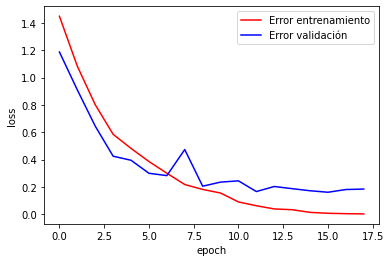

In [185]:
## Especificamos fución de perdida (loss) y optimizador
# loss
criterion = nn.CrossEntropyLoss()
# optimizador
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.07)

# numero de epochs para entrenar el modelo
n_epochs = 18
lossesT = []
lossesV = []
modelo.train() # prep model for training
# inicializa listas para monitorizar la precisión
class_correct_train = list(0. for i in range(5)) #5
class_total_train = list(0. for i in range(5)) #5
class_correct_valid = list(0. for i in range(5)) #5
class_total_valid = list(0. for i in range(5)) #5

for epoch in range(n_epochs):

    #Entrenar el modelo
    # monitor training loss
    train_loss = 0.0    
    for train_img, train_lab in train_loader:
      #  model.train() # prep model for training
        batch_size = train_img.size(0)
        # inicializa los gradientes de todas las variables que optimizamos
        optimizer.zero_grad()    
        # paso forward: predice etiquetas de los datos de entrenamiento
        output = modelo(train_img)
        # calcula loss
        loss = criterion(output, train_lab.type(torch.LongTensor))
        # backward pass: calcula gradiente de la loss con respecto parámetros del modelo
        loss.backward()
        # actualiza parametros
        optimizer.step()
        # actualiza loss
        train_loss += loss.item()*batch_size
        # Para la evaluación del porcentaje de aciertos:
        # convierte la probabilidad de salida a clase
        _, pred = torch.max(output, 1) #
        # compara predicciones con etiquetas ground truth
        correct = np.squeeze(pred.eq(train_lab.data.view_as(pred)))
         # calcular precisión
        for i in range(batch_size):
            # guarda etiqueta ground truth para la muestra actual del batch actual
            label = int(train_lab.data[i])
            # suma +1 a los aciertos de esta etiqueta, si corrent[i] es True
            class_correct_train[label] += correct[i].item()
            # aumenta el total de muestras con esta etiqueta
            class_total_train[label] += 1

    #Para el conjunto de validación:
    valid_loss = 0.0
    for valid_img, valid_lab in valid_loader:
      #  model.eval() # prep model for training
        batch_size = valid_img.size(0)
        # paso forward: predice etiquetas de los datos de validación
        output = modelo(valid_img)
        # calcula loss
        loss = criterion(output,valid_lab.type(torch.LongTensor))
        # actualiza loss
        valid_loss += loss.item() * batch_size
        # Para la evaluación del porcentaje de aciertos:
        # convierte la probabilidad de salida a clase
        _, pred = torch.max(output, 1) #
        # compara predicciones con etiquetas ground truth
        correct = np.squeeze(pred.eq(valid_lab.data.view_as(pred)))
        # calcula precisión:
        for i in range(batch_size):
            # guarda etiqueta ground truth para la muestra actual del batch actual
            label = int(valid_lab.data[i])
            # suma +1 a los aciertos de esta etiqueta, si corrent[i] es True
            class_correct_valid[label] += correct[i].item()
            # aumenta el total de muestras con esta etiqueta
            class_total_valid[label] += 1

  

    # calcula la loss media para un epoch entero
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    lossesT.append(train_loss)
    lossesV.append(valid_loss)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))
    print('Epoch: {} \tValid Loss: {:.6f}'.format(
        epoch+1, 
        valid_loss
        ))

#Gráfica de los valores de loss a lo largo de un entrenamiento    
plt.plot(range(n_epochs), lossesT, color='red', label="Error entrenamiento")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.plot(range(n_epochs), lossesV, color='blue', label="Error validación")
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

#Muestra el % de aciertos del conjunto de entrenamiento
for i in range(5):
    if class_total_train[i] > 0:
        print('Train Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct_train[i] / class_total_train[i],
            np.sum(class_correct_train[i]), np.sum(class_total_train[i])))
    else:
        print('Train Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTrain Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct_train) / np.sum(class_total_train),
    np.sum(class_correct_train), np.sum(class_total_train)))

#Muestra el % de aciertos del conjunto de validación
#validacion
print('\n')
for i in range(5):
    if class_total_valid[i] > 0:
        print('Valid Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct_valid[i] / class_total_valid[i],
            np.sum(class_correct_valid[i]), np.sum(class_total_valid[i])))
    else:
        print('Valid Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nValid Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct_valid) / np.sum(class_total_valid),
    np.sum(class_correct_valid), np.sum(class_total_valid)))
